In [1]:
import numpy as np

from mushroom_hyperscanning.data import load_eeg

In [2]:
SUBJECT = "01"
CEREMONY = "ceremony1"
BIDS_ROOT = "../data/003_sanitization"

In [27]:
raw = load_eeg(SUBJECT, CEREMONY, root=BIDS_ROOT, preload=True)
raw.crop(tmin=1000, tmax=1000 + 60 * 1)  # use 20 minutes of data to test

Extracting EDF parameters from /home/hyruuk/GitHub/cocolab/mushroom_hyperscanning/data/003_sanitization/sub-01/ses-ceremony1/eeg/sub-01_ses-ceremony1_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5612999  =      0.000 ... 18709.997 secs...


/home/hyruuk/GitHub/cocolab/mushroom_hyperscanning/mushroom_hyperscanning/data.py:36: RuntimeWarning: The unit for channel(s) CM has changed from V to NA.
  raw.info.set_channel_types({ch: CH_TYPE_MAPPING[ch] if ch in CH_TYPE_MAPPING else "eeg" for ch in raw.ch_names})


<RawEDF | sub-01_ses-ceremony1_task-psilo_eeg.edf, 23 x 18001 (60.0 s), ~3.2 MiB, data loaded>

In [28]:
import neurokit2 as nk

# select ecg channel from raw
ecg = raw.copy().pick("ECG").get_data().squeeze()

signals, info = nk.ecg_process(ecg, sampling_rate=raw.info['sfreq'])



(18001,)


{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([  296,   548,   804,  1055,  1313,  1575,  1830,  2088,  2348,
         2602,  2860,  3117,  3368,  3623,  3876,  4123,  4375,  4624,
         4866,  5118,  5378,  5634,  5888,  6139,  6395,  6651,  6904,
         7162,  7415,  7675,  7936,  8191,  8453,  8716,  8974,  9240,
         9505,  9766, 10033, 10297, 10559, 10826, 11092, 11353, 11618,
        11880, 12139, 12400, 12657, 12920, 13177, 13433, 13694, 13948,
        14205, 14458, 14713, 14971, 15224, 15484, 15740, 15993, 16250,
        16506, 16760, 17019, 17273, 17533, 17788]),
 'ECG_R_Peaks_Uncorrected': array([  296,   548,   804,  1055,  1313,  1575,  1830,  2088,  2348,
         2602,  2860,  3117,  3368,  3623,  3876,  4123,  4375,  4624,
         4866,  5118,  5378,  5634,  5888,  6139,  6399,  6651,  6904,
         7162,  7415,  7675,  7936,  8191,  8453,  8716,  8974,  9240,
         9505,  9766, 10033, 10297, 10559, 10826, 11092, 11353, 1161

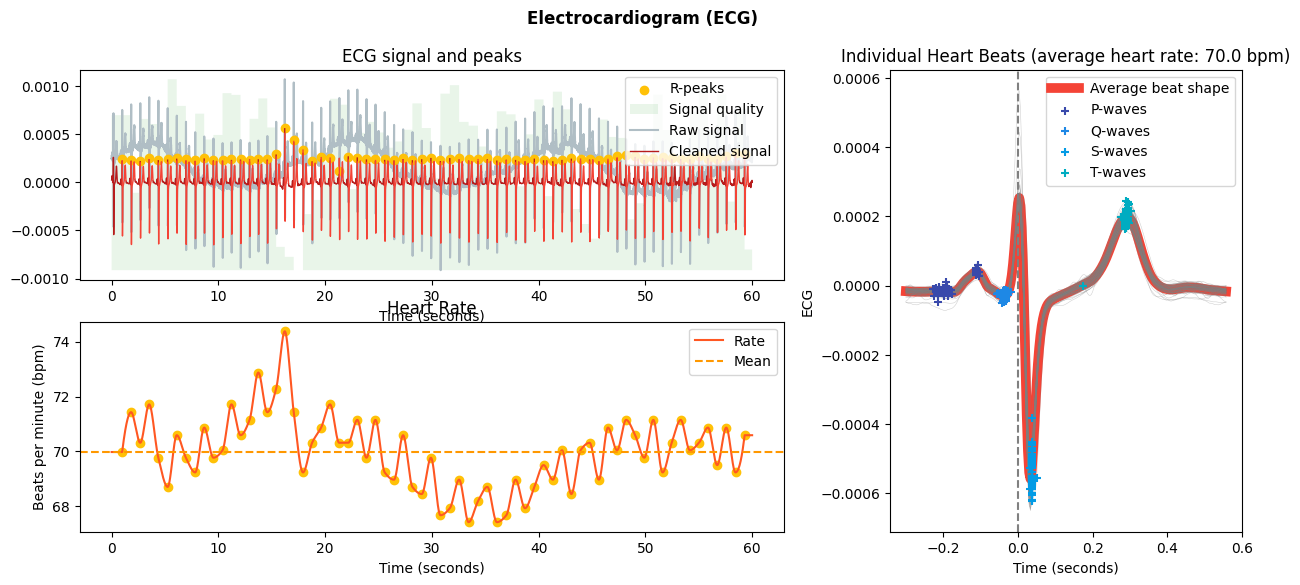

In [36]:
import matplotlib.pyplot as plt

nk.ecg_plot(signals, info)
fig = plt.gcf()
fig.set_size_inches(15, 6, forward=True)
plt.plot()



print(ecg.shape)
info

In [ ]:
import numpy as np
import mne

def preprocess_ecg_mne(
    raw,
    ecg_ch=None,
    l_freq=0.5,
    h_freq=40.0,
    notch_freqs=(60.0,),      # Mexico mains
    use_neurokit2=True,       # NK2 for detection
    min_bpm=35,               # physio lower bound
    max_bpm=200,              # physio upper bound
    outlier_rr_std=3.5,       # MAD-based pruning
    hr_align_to_eeg=True,     # HR at EEG sfreq
    hr_sfreq=None,            # used if hr_align_to_eeg=False
    add_hr_channel=True,
    hr_channel_name="HR"
):
    """Preprocess ECG in an MNE Raw; detect/fix R-peaks; build HR trace aligned to EEG."""
    raw = raw.copy()

    # --- ECG channel
    if ecg_ch is None:
        picks = mne.pick_types(raw.info, ecg=True)
        if len(picks) == 0:
            raise ValueError("No ECG channel found. Pass ecg_ch or set a channel type to 'ecg'.")
        ecg_ch = raw.ch_names[picks[0]]
    if raw.get_channel_types(picks=[ecg_ch])[0] != "ecg":
        raw.set_channel_types({ecg_ch: "ecg"})

    sfreq = float(raw.info["sfreq"])

    # --- Filtering
    if notch_freqs:
        raw.notch_filter(freqs=list(notch_freqs), picks=[ecg_ch], method="spectrum_fit")
    raw.filter(l_freq=l_freq, h_freq=h_freq, picks=[ecg_ch],
               method="fir", phase="zero", fir_window="hamming")  # (no detrend in Raw.filter)

    # --- R-peak detection (NeuroKit2 → fallback to MNE)
    from mne.preprocessing import find_ecg_events
    if use_neurokit2:
        try:
            import neurokit2 as nk
            # NK2 cleaning + peaks
            ecg = raw.get_data(picks=[ecg_ch])[0]
            ecg_clean = nk.ecg_clean(ecg, sampling_rate=sfreq, method="neurokit")
            _, nkinfo = nk.ecg_peaks(ecg_clean, sampling_rate=sfreq)
            peaks_idx = nkinfo.get("ECG_R_Peaks", None)
            if peaks_idx is None or len(peaks_idx) < 2:
                ecg_events, _, _ = find_ecg_events(raw, ch_name=ecg_ch, event_id=999)
                r_peaks_samp = ecg_events[:, 0]
            else:
                r_peaks_samp = np.asarray(peaks_idx, dtype=int)
        except Exception:
            ecg_events, _, _ = find_ecg_events(raw, ch_name=ecg_ch, event_id=999)
            r_peaks_samp = ecg_events[:, 0]
    else:
        ecg_events, _, _ = find_ecg_events(raw, ch_name=ecg_ch, event_id=999)
        r_peaks_samp = ecg_events[:, 0]

    r_peaks_samp = np.asarray(r_peaks_samp, dtype=int)
    r_peaks_time = r_peaks_samp / sfreq

    # --- Physio-constrained RR (remove implausible beats first)
    # keep RR within [60/max_bpm, 60/min_bpm] seconds
    if r_peaks_time.size >= 3:
        rr = np.diff(r_peaks_time)
        lo = 60.0 / max_bpm
        hi = 60.0 / min_bpm
        keep_rr = (rr >= lo) & (rr <= hi)
        # Map interval mask to peaks (keep peaks that are interior to valid intervals)
        keep_peaks = np.r_[True, keep_rr] & np.r_[keep_rr, True]
        r_peaks_samp = r_peaks_samp[keep_peaks]
        r_peaks_time = r_peaks_time[keep_peaks]

    # --- MAD-based ectopic/outlier pruning (robust to residual artifacts)
    rr_s = np.diff(r_peaks_time)
    if outlier_rr_std is not None and rr_s.size > 4:
        med = np.median(rr_s)
        mad = 1.4826 * np.median(np.abs(rr_s - med) + 1e-12)
        scale = mad if mad > 0 else (np.std(rr_s) + 1e-12)
        z = (rr_s - med) / scale
        keep = np.abs(z) < outlier_rr_std
        keep_peaks = np.r_[True, keep] & np.r_[keep, True]
        r_peaks_samp = r_peaks_samp[keep_peaks]
        r_peaks_time = r_peaks_time[keep_peaks]
        rr_s = np.diff(r_peaks_time)
    else:
        rr_s = np.diff(r_peaks_time)

    # --- events + annotations
    event_id = 999
    events = np.c_[r_peaks_samp, np.zeros_like(r_peaks_samp, dtype=int), np.full_like(r_peaks_samp, event_id, dtype=int)]
    annotations_added = False
    if r_peaks_time.size > 0:
        ann = mne.Annotations(onset=r_peaks_time,
                              duration=np.full_like(r_peaks_time, 0.01, dtype=float),
                              description=["R-peak"] * len(r_peaks_time))
        raw.set_annotations(raw.annotations + ann if len(raw.annotations) else ann)
        annotations_added = True

    # --- Continuous HR (BPM), aligned to EEG by default
    hr_inst = None
    if r_peaks_time.size >= 3:
        mid_t = (r_peaks_time[1:] + r_peaks_time[:-1]) / 2.0
        bpm = 60.0 / np.diff(r_peaks_time)
        target_sfreq = sfreq if hr_align_to_eeg else (float(hr_sfreq) if hr_sfreq is not None else 10.0)
        t0, t1 = float(raw.times[0]), float(raw.times[-1])
        tgrid = np.arange(t0, t1, 1.0 / target_sfreq)

        if mid_t.size >= 2:
            valid = np.isfinite(bpm)
            bpm_grid = np.interp(tgrid, mid_t[valid], bpm[valid], left=np.nan, right=np.nan)
        else:
            bpm_grid = np.full_like(tgrid, np.nan, dtype=float)

        hr_inst = dict(times=tgrid, bpm=bpm_grid)

        if add_hr_channel:
            x = bpm_grid.copy()
            if not np.all(np.isnan(x)):
                idx_valid = np.where(~np.isnan(x))[0]
                first, last = idx_valid[0], idx_valid[-1]
                x[:first] = x[first]
                x[last+1:] = x[last]
                nan_idx = np.isnan(x)
                if nan_idx.any():
                    x[nan_idx] = np.interp(np.flatnonzero(nan_idx), np.flatnonzero(~nan_idx), x[~nan_idx])
            hr_info = mne.create_info([hr_channel_name], sfreq=target_sfreq, ch_types=["misc"])
            hr_raw = mne.io.RawArray(x[np.newaxis, :], hr_info)
            # ensure equal length/timebase
            min_len = min(hr_raw.n_times, raw.n_times)
            if hr_raw.n_times != min_len:
                hr_raw = hr_raw.crop(tmin=0, tmax=(min_len - 1) / target_sfreq)
            if raw.n_times != min_len:
                raw = raw.copy().crop(tmin=0, tmax=(min_len - 1) / raw.info["sfreq"])
            raw.add_channels([hr_raw], force_update_info=True)

    return dict(
        raw=raw,
        ecg_ch=ecg_ch,
        r_peaks_samp=r_peaks_samp,
        r_peaks_time=r_peaks_time,
        rr_s=rr_s,
        hr_inst=hr_inst,
        events=events.astype(int),
        annotations_added=annotations_added,
    )


In [12]:
out = preprocess_ecg_mne(raw, use_neurokit2=True, hr_align_to_eeg=True, add_hr_channel=True)
print(len(out["r_peaks_time"]), "R-peaks; median RR =", np.median(out["rr_s"]))
print("HR channel present:", "HR" in out["raw"].ch_names)


Filtering raw data in 1 contiguous segment


Removed notch frequencies (Hz):
     60.00 :  239 windows
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1981 samples (6.603 s)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'dict'